In [1]:
%load_ext watermark
import numpy as np
import pandas as pd

## Load the JupyterHub logs

In [2]:
columns = ['user', 'machine', 'session_start', 'session_end', 'session_length', 'log_file']

In [3]:
df_all = pd.read_csv("../data/jhub_logs.csv.gz", parse_dates=["session_start", "session_end"])
df_all["session_length"] = (df_all.session_end - df_all.session_start).dt.total_seconds().div(60)
df_all = df_all[columns]
df_all.head()

,user,machine,session_start,session_end,session_length,log_file
0,20d8049712498ad1e232,cheyenne,2019-10-27 14:40:21,2019-10-27 16:40:40,120.316667,9d18154b478a74b5048d
1,20d8049712498ad1e232,cheyenne,2019-10-17 09:04:13,2019-10-17 11:04:20,120.116667,3aebf8397c312169a649
2,20d8049712498ad1e232,cheyenne,2019-10-18 16:40:04,2019-10-18 16:42:08,2.066667,0af27edd1d54f8f64735
3,20d8049712498ad1e232,cheyenne,2019-10-18 11:44:28,2019-10-18 12:18:35,34.116667,044c2c11e5ebf6972a1d
4,20d8049712498ad1e232,cheyenne,2019-10-17 15:42:48,2019-10-17 15:46:53,4.083333,2055777649346c360841


In [4]:
df_all["machine"].unique()

array(['cheyenne', 'casper', nan], dtype=object)

In [5]:
dfs = {'all': df_all,
       'Cheyenne': df_all[df_all["machine"] == 'cheyenne'],
       'Casper': df_all[df_all["machine"] == 'casper']}

## Basic Statistics

Some basic statistics from the logs.

In [6]:
print(f'Total number of sessions:')
for name in dfs:
    print(f'{name.rjust(10)}:   {len(dfs[name])}')

Total number of sessions:
       all:   15650
  Cheyenne:   9492
    Casper:   6157


In [7]:
def print_span(name):
    print(f'Total span of {name} logs:  {dfs[name].session_end.max() - dfs[name].session_start.min()}')
    print(f'   From: {dfs[name].session_start.min()}')
    print(f'   To:   {dfs[name].session_end.max()}')

for name in dfs:
    print_span(name)
    print()

Total span of all logs:  453 days 16:36:23
   From: 2019-05-21 16:49:20
   To:   2020-08-17 09:25:43

Total span of Cheyenne logs:  440 days 19:47:09
   From: 2019-06-03 13:38:34
   To:   2020-08-17 09:25:43

Total span of Casper logs:  453 days 16:34:29
   From: 2019-05-21 16:49:20
   To:   2020-08-17 09:23:49



In [8]:
def print_lengths(name):
    print(f'Session Lengths on {name} [minutes]:')
    print(f'   Minimum:  {dfs[name].session_length.min()}')
    print(f'   Maximum:  {dfs[name].session_length.max()}')
    print(f'   Mean:     {dfs[name].session_length.mean()}')
    print(f'   Median:   {dfs[name].session_length.median()}')

for name in dfs:
    print_lengths(name)
    print()

Session Lengths on all [minutes]:
   Minimum:  0.0
   Maximum:  8075.883333333334
   Mean:     155.07645642959082
   Median:   120.0

Session Lengths on Cheyenne [minutes]:
   Minimum:  0.0
   Maximum:  8075.883333333334
   Mean:     172.20493222362694
   Median:   120.23333333333333

Session Lengths on Casper [minutes]:
   Minimum:  0.0
   Maximum:  1439.9166666666667
   Mean:     128.67017216176708
   Median:   90.78333333333333



In [9]:
print(f'Total Number of Unique Users:')
for name in dfs:
    print(f'{name.rjust(10)}:   {dfs[name].user.nunique()}')

Total Number of Unique Users:
       all:   256
  Cheyenne:   245
    Casper:   139


## Tutorials

Three tutorials have been given during the duration of the logs.  We note the dates for these tutorials so that we can reference their times in the plots below.

In [10]:
tutorials = {'jun': ["2019-06-03", "2019-06-05"],
             'sep': ["2019-09-18", "2019-09-20"],
             'oct': ["2019-10-16", "2019-10-18"]}

## Sessions by Day & Month

First, we take a look at the number of sessions per day over the span of the logs.

In [11]:
days = pd.date_range(dfs['all'].session_start.min(),
                     dfs['all'].session_end.max() + pd.DateOffset(days=1),
                     freq='D').normalize()
mons = pd.date_range(dfs['all'].session_start.min() - pd.DateOffset(months=1),
                     dfs['all'].session_end.max() + pd.DateOffset(months=1),
                     freq='MS').normalize()

In [12]:
sess_per_day = pd.DataFrame()
sess_per_mon = pd.DataFrame()
for name in dfs:
    sess_per_day[name] = 0.5 * (dfs[name].groupby(pd.cut(dfs[name].session_start, days)).size() +
                                dfs[name].groupby(pd.cut(dfs[name].session_end, days)).size()).rename(f'Sessions per Day ({name})')
    sess_per_mon[name] = 0.5 * (dfs[name].groupby(pd.cut(dfs[name].session_start, mons)).size() +
                                dfs[name].groupby(pd.cut(dfs[name].session_end, mons)).size()).rename(f'Sessions per Month ({name})')

/Users/kpaul/Software/miniconda3/envs/jhubanal/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


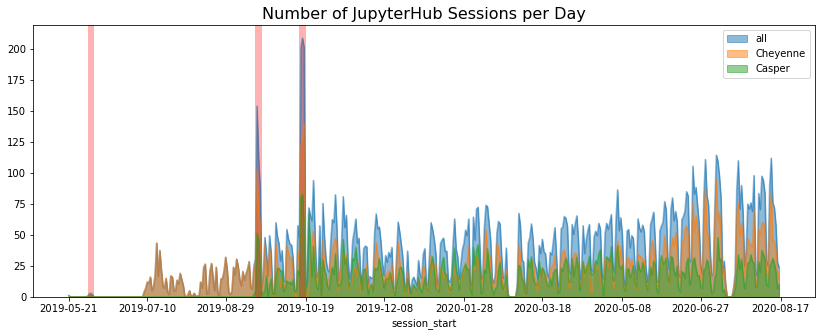

In [13]:
ax = sess_per_day.plot.area(figsize=(14,5), stacked=False)
xticks = np.linspace(0, len(days)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([days[i].strftime('%Y-%m-%d') for i in xticks])
ax.set_title('Number of JupyterHub Sessions per Day', fontsize=16)
for tutorial in tutorials:
    t1, t2 = tutorials[tutorial]
    ax.axvspan(days.get_loc(t1)-1, days.get_loc(t2)+1, facecolor='r', alpha=.3, edgecolor='none')

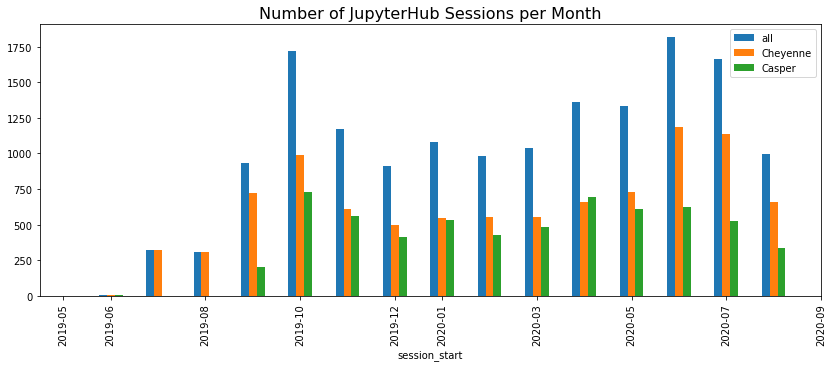

In [14]:
ax = sess_per_mon.plot.bar(figsize=(14,5))
xticks = np.linspace(0, len(mons)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([mons[i].strftime('%Y-%m') for i in xticks])
ax.set_title('Number of JupyterHub Sessions per Month', fontsize=16);

**NOTE:** You can see a definite up-tick in the number of sessions following the September and October tutorials.  During this period of time, from August through October, the average number of sessions per day and month more than doubles.

## Unique Users by Day & Month

Next, we look at the number of unique users per day and per month.

In [15]:
users_per_day = pd.DataFrame()
users_per_mon = pd.DataFrame()
for name in dfs:
    users_per_day[name] = 0.5 * (dfs[name].user.groupby(pd.cut(dfs[name].session_start, days)).nunique() +
                                 dfs[name].user.groupby(pd.cut(dfs[name].session_end, days)).nunique()).rename(f'Unique Users per Day ({name})')
    users_per_mon[name] = 0.5 * (dfs[name].user.groupby(pd.cut(dfs[name].session_start, mons)).nunique() +
                                 dfs[name].user.groupby(pd.cut(dfs[name].session_end, mons)).nunique()).rename(f'Unique Users per Month ({name})')

/Users/kpaul/Software/miniconda3/envs/jhubanal/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


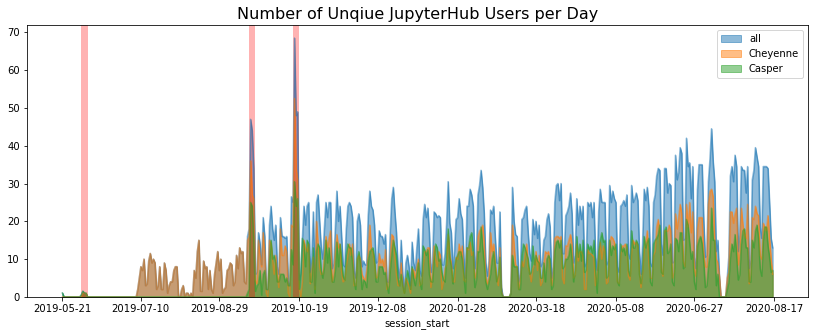

In [16]:
ax = users_per_day.plot.area(figsize=(14,5), stacked=False)
xticks = np.linspace(0, len(days)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([days[i].strftime('%Y-%m-%d') for i in xticks])
ax.set_title('Number of Unqiue JupyterHub Users per Day', fontsize=16)
for tutorial in tutorials:
    t1, t2 = tutorials[tutorial]
    ax.axvspan(days.get_loc(t1)-1, days.get_loc(t2)+1, facecolor='r', alpha=.3, edgecolor='none')

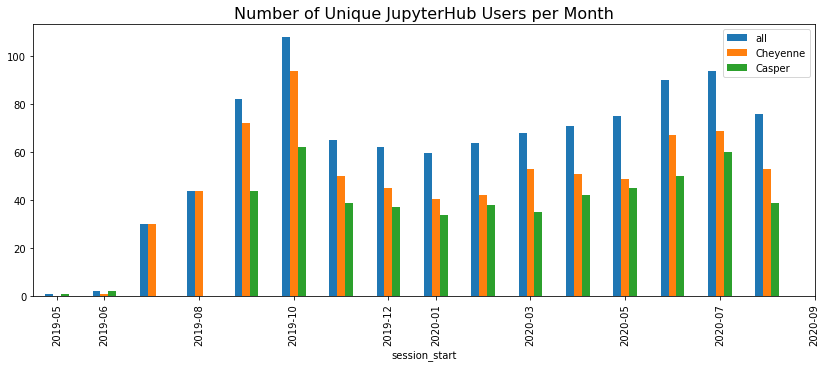

In [17]:
ax = users_per_mon.plot.bar(figsize=(14,5))
xticks = np.linspace(0, len(mons)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([mons[i].strftime('%Y-%m') for i in xticks])
ax.set_title('Number of Unique JupyterHub Users per Month', fontsize=16);

**NOTE:** Again, you can note a growth in users following each tutorial/hackathon (September and October).  

In [18]:
%watermark -iv -d -u

numpy  1.19.1
pandas 1.1.1
last updated: 2020-08-25
